Notebook purpose:

- Develop a mechanism to calculate the fraction of discretionary spend during the first n days after payday

Approach:

1. Identify regular income payments

2. Identify discretionary spending

3. Calc fraction of discretionary spend during n first days after payday

In [1]:
from imports import *

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

SAMPLE = 'X77'

In [2]:
df = (pd.read_parquet(os.path.join(config.TEMPDIR, f'data_{SAMPLE}.parquet'))
      .sort_values(['user_id', 'transaction_date']))
helpers.info(df)

Users:        659
Rows:   1,670,814
Cols:          23


## Income

### Types of incomes to focus on

In [3]:
inc = (df[df.tag.str.contains('_income')]
       .assign(amount = lambda df: df.amount.mul(-1)))
inc.groupby('tag').amount.describe().T

tag,benefits_income,earnings_income,other_income,pensions_income
count,18298.0000,23287.0000,13395.0000,481.0000
mean,145.6303,1759.5823,145.5797,815.4611
std,145.6275,1503.9353,531.1221,1333.7990
min,1.2600,0.0100,0.0000,9.2000
25%,62.7000,719.0000,0.1600,218.6000
50%,108.9300,1564.1899,1.6500,586.5600
75%,170.9800,2373.0801,35.0000,841.2100
max,2612.2700,54281.8984,21431.0508,25719.0801


I'll start by **focusing on earnings only**, as all other types either occur rarely or are of small amounts. I might have to take into account pensions (mainly intestments) at some point, as they might introduce too much noise.

### Pension detour

I drop retirees from sample. Check who gets paid pensions (probably people who retire before 65).

In [4]:
mask = inc.tag.str.contains('pension')
inc[mask].auto_tag.value_counts()[:10]

work pension              225
pension                   105
no tag                     63
benefits                   60
salary or wages - main     13
pension or investments     12
transfers                   1
family benefits             1
cash                        1
Name: auto_tag, dtype: int64

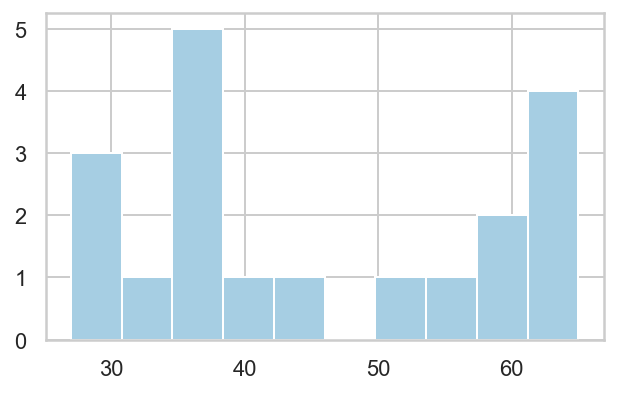

In [5]:
mask = inc.auto_tag.str.contains('work pension|pension')
ages = 2020 - inc[mask].groupby('user_id').first().year_of_birth
ages.hist(figsize=(5, 3));

Not quite what I expected, but the numbers are too small to matter. Ignoring this for now.

### Number of days between paydays

Focus on earnings only

In [6]:
inc = (df[df.tag.eq('earnings_income')]
       .assign(amount = lambda df: df.amount.mul(-1)))

In [7]:
diff = (inc.sort_values(['user_id', 'transaction_date'])
        .groupby('user_id')
        .transaction_date.diff()
        .dt.days)

In [8]:
diff.describe(percentiles=[.1, .25, .5, .75, .8, .9, .95, .99])

count    22664.0000
mean        23.3084
std         22.5437
min          0.0000
10%          3.0000
25%          8.0000
50%         28.0000
75%         31.0000
80%         31.0000
90%         33.0000
95%         35.0000
99%         62.0000
max       1277.0000
Name: transaction_date, dtype: float64

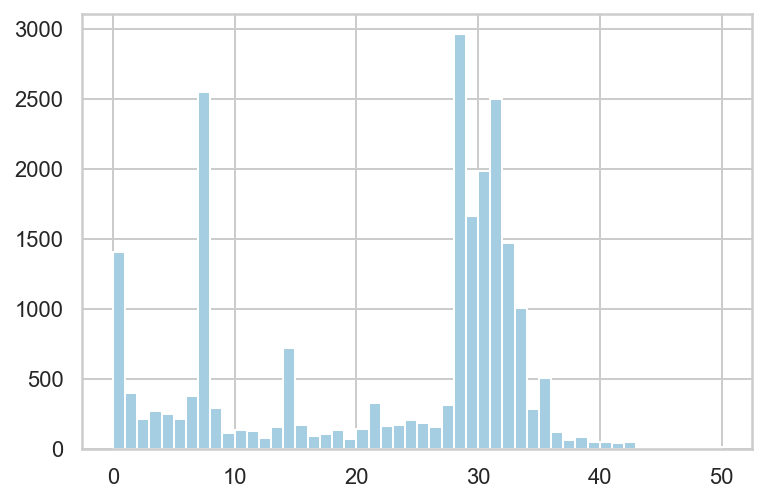

In [9]:
diff[diff < 50].hist(bins=np.linspace(0, 50, 51));

What's going on with zero days?

In [10]:
import random

zeroes = diff[diff.eq(0)].index
zero_dates = inc.loc[zeroes].set_index(['user_id', 'transaction_date']).index
zero = inc.set_index(['user_id', 'transaction_date']).loc[zero_dates].reset_index()
zero = zero[zero.tag.str.contains('_income')]
dates = zero.transaction_date.unique()

In [11]:
rnd_date = random.choice(dates)

In [12]:
rand = zero[zero.transaction_date.eq(rnd_date)]
helpers.reorder(rand, ['transaction_id', 'account_id', 'account_type'])[:4]

,transaction_id,account_id,account_type,user_id,transaction_date,amount,transaction_description,merchant_name,auto_tag,tag,manual_tag,gender,latest_balance,up_tag,salary_range,year_of_birth,merchant_business_line,account_last_refreshed,user_registration_date,account_created,postcode,credit_debit,bank
699,53564353,349605,current,253077,2014-12-05,36.0,<mdbremoved> bac,no merchant,no tag,earnings_income,salary - secondary,f,0.0,salary - secondary,NaN,1986.0,no merchant business line,2017-03-17 00:05:00,2015-01-16,2015-01-16,hu2 8,credit,natwest bank
700,53564352,349605,current,253077,2014-12-05,287.0,<mdbremoved>,no merchant,salary or wages - main,earnings_income,salary or wages - main,f,0.0,salary or wages - main,NaN,1986.0,no merchant business line,2017-03-17 00:05:00,2015-01-16,2015-01-16,hu2 8,credit,natwest bank


Quite often, zero differences result from identical payments (e.g. 25 July 2018). Discuss with Daniel.

**For now, I just aggragate all payments within a day.**

In [13]:
inc = (df[df.tag.str.contains('earnings_income')]
       .assign(amount = lambda df: df.amount.mul(-1))
       .groupby(['user_id', 'transaction_date']).amount.sum()
       .reset_index())

Again look at differences

In [14]:
diff = inc.set_index('user_id').groupby('user_id').transaction_date.diff().dt.days.dropna()
diff.describe(percentiles=[.95, .99])

count    21258.0000
mean        24.8500
std         22.4393
min          1.0000
50%         28.0000
95%         35.0000
99%         63.0000
max       1277.0000
Name: transaction_date, dtype: float64

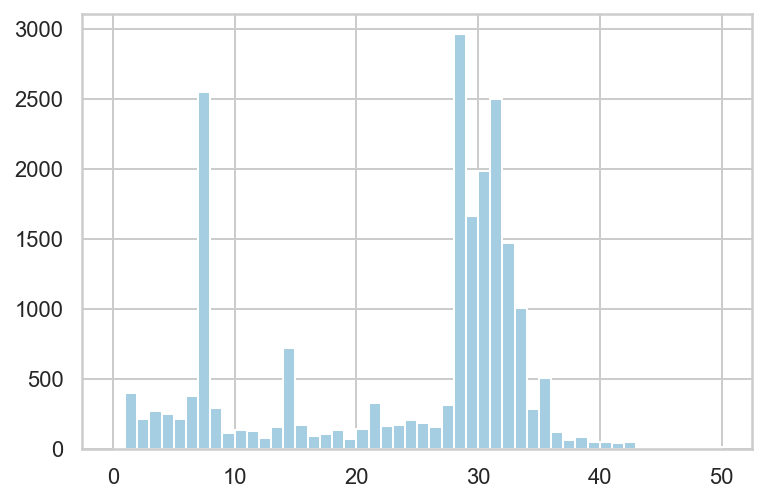

In [15]:
diff[diff < 50].hist(bins=np.linspace(0, 50, 51));

### Focus on monthly salary recipients

In [16]:
def monthly(g):
    return all((g > 25) & (g < 35))
    
users = diff.groupby('user_id').apply(monthly)
users = users[users].index
mon = df[df.user_id.isin(users)]
helpers.info(mon)

Users:        109
Rows:     208,332
Cols:          23


Look at monthly income distribution:

In [17]:
month = pd.Grouper(freq='M', key='transaction_date')
yearly_inc = (mon[mon.tag.eq('earnings_income')]
           .groupby(['user_id', month])
           .amount.sum()
           .groupby('user_id')
           .mean().mul(-12))
yearly_inc.describe()

count      109.0000
mean     24054.3242
std      12953.2578
min       5049.5400
25%      16035.8809
50%      21706.0273
75%      28378.3203
max      86669.5000
Name: amount, dtype: float64

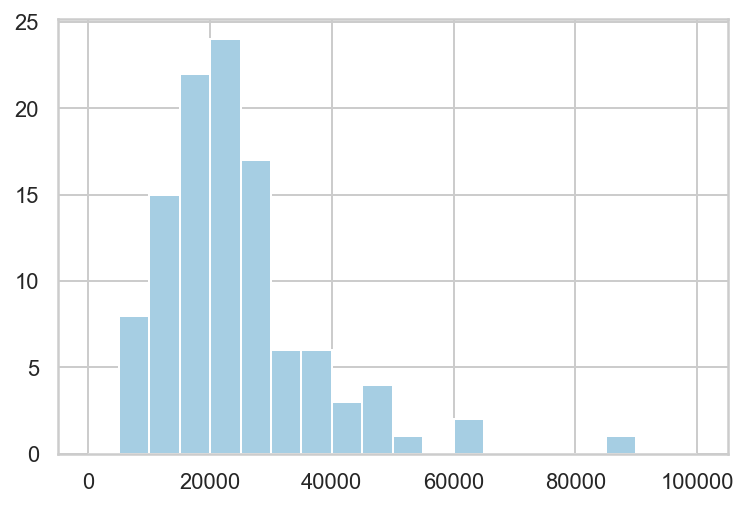

In [18]:
yearly_inc.hist(bins=np.linspace(0, 100_000, 21));

Looks sensible.

#### Function to identify users with monthly salaries

In [19]:
def monthly_salary(df): 
    """Keep users with one monthly salary payment."""
    payday_diff = (df[df.tag.str.contains('earnings_income')]
                  .groupby(['user_id', 'transaction_date'])
                  .amount.sum()
                  .reset_index(level=1)
                  .groupby('user_id')
                  .transaction_date.diff().dt.days
                  .dropna())
    
    def helper(g):
        return all((g > 25) & (g < 35))
    
    users = payday_diff.groupby('user_id').filter(helper).index.unique()    
    return df[df.user_id.isin(users)]

r = monthly_salary(df)

In [20]:
helpers.info(r)

Users:        109
Rows:     208,332
Cols:          23


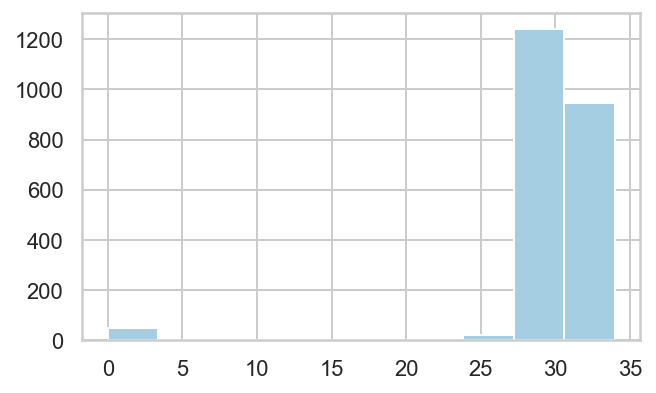

In [21]:
(r[r.tag.eq('earnings_income')]
 .groupby('user_id')
 .transaction_date.diff().dt.days
 .hist(figsize=(5, 3)));

Remember: there are a few zero difference transations for cases where people receive multiple payments on the same day. In the selection of the sample, payments on the same day are summed, so such cases cannot occur. In the resulting data, though, we don't sum daily transactions, and calculating the diffs as above (without summing same-day payments) results in a few zeroes.

## Spending

Options:

- Hacioglu et al. (2020): durable, non-durable, services, retail

- Gelman et al. (2014): total, non-recurring, highly-discretionary (fast food and coffee)

- Kuchler and Pagel (2020): ..., short-run consumables (incl. restaurants, Netflix, etc.)

In [22]:
dd = monthly_salary(df)
helpers.info(dd)

Users:        109
Rows:     208,332
Cols:          23


### Highly-discretionary spending

See expenditure_classification.ipyny

### Proof of concept: coffee shop expenditure

In [23]:
def coffee_data(df):
    """Calculte user-level coffee spend by days since last payday."""
    df = df.copy()
    cols = 'user_id transaction_date transaction_description tag amount'.split()
    df = df[cols]
    
    # add coffee spend and date of last salary payment
    shops = 'starbucks nero costa'.split()
    coffee_spend = df.transaction_description.str.contains('|'.join(shops))
    df['coffee'] = np.where(coffee_spend, df.amount, 0)
    salary_pmt = df.tag.eq('earnings_income')
    df['last_payday'] = np.where(salary_pmt, df.transaction_date, np.datetime64('NaT'))
    
    # aggregate to daily frequency
    df = (df.groupby(['user_id', 'transaction_date'])
          .agg({'coffee': sum, 'last_payday': max})
          .reset_index())
    
    # forward fill last payday column and drop days prior to first payday
    df['last_payday'] = df.groupby('user_id').last_payday.ffill()

    df['delta'] = (df.transaction_date - df.last_payday).dt.days
    mask = df.delta.lt(35) & df.coffee.gt(0)  
    return df.loc[mask, ['coffee', 'delta']]

coffee = coffee_data(dd)
coffee.describe()

,coffee,delta
count,1281.0000,1281.0000
mean,5.1742,13.8657
std,3.7984,8.4181
min,0.0500,0.0000
25%,2.5200,6.0000
50%,3.8500,13.0000
75%,6.5000,20.0000
max,39.3000,32.0000


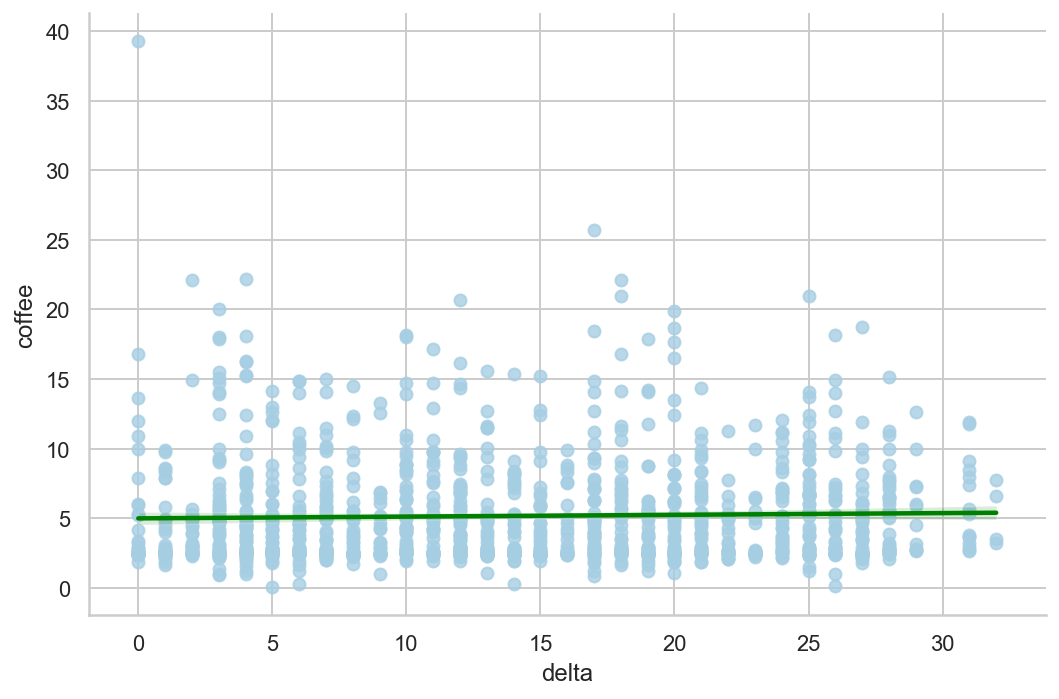

In [24]:
sns.lmplot(x='delta', y='coffee', data=coffee, ci=95, fit_reg=True,
           line_kws=dict(color='green'), height=5, aspect=1.5);

In [25]:
res = smf.ols('coffee ~ delta', data=coffee).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 coffee   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9997
Date:                Sun, 18 Oct 2020   Prob (F-statistic):              0.318
Time:                        15:12:24   Log-Likelihood:                -3526.2
No. Observations:                1281   AIC:                             7056.
Df Residuals:                    1279   BIC:                             7067.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9993      0.205     24.440      0.0